# Offline Phase: GEIM algorithm
**Aim of the tutorial:** this notebook shows how to perform the offline phase of the GEIM algorithm, i.e. how to use this method to generate the magic functions and the associared magic sensors from a parametric dataset.

----

*To execute this notebook* it is necessary to have the snapshots stored in `Snapshots` folder, placed in this directory (otherwise modify `path_FOM` variable).

In [1]:
import numpy as np
import os
from IPython.display import clear_output
import pickle

from dolfinx.fem import FunctionSpace

from pyforce.tools.backends import LoopProgress
from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store
from pyforce.tools.functions_list import FunctionsList

import matplotlib.pyplot as plt
from matplotlib import cm

path='./Offline_results/'
if not os.path.exists(path):
    os.makedirs(path)

The geometry is imported from "ANL11A2_octave.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [3]:
from neutronics import create_anl11a2_mesh

domain, _, _ = create_anl11a2_mesh(use_msh=False, save_mesh=False)

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

clear_output()

In [4]:
type(domain)

dolfinx.mesh.Mesh

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures. The snapshots live in a functional space: piecewise linear functions.

In [3]:
V = FunctionSpace(domain, ("Lagrange", 1))

Defining the variables to load

In [4]:
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]

Let us load the train snapshots.

In [5]:
path_FOM = './Snapshots/'

train_snaps = list()

for field_i in range(len(var_names)):
    train_snaps.append(FunctionsList(V))

    tmp_FOM_list, _ = ImportH5(V, path_FOM+'train_snap_'+var_names[field_i], var_names[field_i])
    
    for mu in range(len(tmp_FOM_list)):
        train_snaps[field_i].append(tmp_FOM_list(mu))
    
    del tmp_FOM_list      

## GEIM algorithm

The *greedy* procedure is summarised in the following figure.

![GEIM](GEIM-algo.png)

More information about the method can be found in [Maday et al. (2014)](https://doi.org/10.1016/j.cma.2015.01.018) and [Introini et al. (2023)](https://doi.org/10.1016/j.cma.2022.115773).

### Generation of the magic functions/sensors
The GEIM is used to generated through a greedy process a set of basis functions and basis sensors for the data assimilation process.

Sensors are mathematically modelled as linear continuous functionals $v_m(\cdot)$, defined as
\begin{equation*}
v_m(u(\mathbf{x});\,\mathbf{x}_m,\,s)=\int_\Omega u(\mathbf{x})\cdot \mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\,d\Omega
\end{equation*}
given $\mathbf{x}_m$ the centre of mass of the functional and $s$ its point spread. The current version adopts Gaussian kernels 
\begin{equation*}
\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right) = \frac{e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}}{\displaystyle\int_\Omega e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}\,d\Omega}
\end{equation*}
such that $\|\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\|_{L^1(\Omega)}=1$, this models the measurement process of scalar fields.

A dictionary will be created for each GEIM with the keys consistent with the `var_names` variable.
Moreover, the GEIM coefficients will be stored in a dictionary with the same keys: these will be needed in the online phase when the measures are polluted by random noise, within the Tikhonov Regularised version of the GEIM algorithm (TR-GEIM), [Introini et al. (2023)](https://doi.org/10.1016/j.cma.2022.115773).

In [6]:
geim_data = dict()
train_GEIMcoeff = dict()

As for the POD in the previous notebook, the maximum number of sensors will be 20. The sensors are characterised by an hyperparameter, the spread $s$, which depends on the specific sensor: two different values will be considered to investigate what is the effect on the reduction process.

In [7]:
Mmax = 20

s = [2, 5]
train_abs_err = np.zeros((Mmax, len(var_names), len(s)))
train_rel_err = np.zeros((Mmax, len(var_names), len(s)))

Here in this cell the `GEIM` class is defined, which will be used to generate the magic functions and sensors. The essential input of the `GEIM` class is the domain from which candidate positions are selected, the functional space, the name of the variable to analyse and the point spread $s$ of the sensors.

In [8]:
from pyforce.offline.geim import GEIM

# This parameter serves as input to select only some cells in the mesh
# It is used to reduce the computational cost of the offline phase
sam_every = 4

for ii in range(len(var_names)):
    geim_data[var_names[ii]] = list()
    train_GEIMcoeff[var_names[ii]] = list()
    
    for jj in range(len(s)):
        
        # Define the GEIM object
        geim_data[var_names[ii]].append(GEIM(domain, V, var_names[ii], s=s[jj]))

The `offline` method is used to generate the magic functions and sensors: it requires as input the train snapshot, the maximum number of sensors to generate. `sampleEvery` and `verbose` are optional parameters.

In [9]:
for ii in range(len(var_names)):
    for jj in range(len(s)):
        
        print('--> '+var_names[ii]+' - s = {:.2e}'.format(s[jj]))
        
        # Perform the offline phase of GEIM
        tmp = geim_data[var_names[ii]][jj].offline(train_snaps[ii], Mmax, 
                                                   sampleEvery = sam_every, verbose = True) 

        # Store output
        train_abs_err[:, ii, jj] = tmp[0].flatten()
        train_rel_err[:, ii, jj] = tmp[1].flatten()
        train_GEIMcoeff[var_names[ii]].append(tmp[2])
        print(' ')
    print(' ')

--> phi_1 - s = 2.00e+00
Generating sensors (sampled every 4 cells): 1718.000 / 1718.00 - 0.003 s/it
  Iteration 020 | Abs Err: 2.41e-04 | Rel Err: 4.68e-06
--> phi_1 - s = 5.00e+00
Generating sensors (sampled every 4 cells): 1718.000 / 1718.00 - 0.004 s/it
  Iteration 020 | Abs Err: 1.54e-04 | Rel Err: 2.97e-06
 
--> phi_2 - s = 2.00e+00
Generating sensors (sampled every 4 cells): 1718.000 / 1718.00 - 0.005 s/it
  Iteration 020 | Abs Err: 3.28e-04 | Rel Err: 1.04e-05
--> phi_2 - s = 5.00e+00
Generating sensors (sampled every 4 cells): 1718.000 / 1718.00 - 0.003 s/it
  Iteration 020 | Abs Err: 3.53e-04 | Rel Err: 1.11e-05
 


Let us store the magic functions and the magic sensors

In [11]:
if not os.path.exists(path+'BasisSensors/'):
    os.makedirs(path+'BasisSensors/')
if not os.path.exists(path+'BasisFunctions/'):
    os.makedirs(path+'BasisFunctions/')
if not os.path.exists(path+'coeffs/'):
    os.makedirs(path+'coeffs/')

for ii in range(len(var_names)):
    for jj in range(len(s)):
        np.savetxt(path+'coeffs/GEIM_'+ var_names[ii] + '_s_{:.2e}'.format(s[jj])+'.txt', train_GEIMcoeff[var_names[ii]][jj],  delimiter=',')
        store(domain, geim_data[var_names[ii]][jj].magic_fun,  'GEIM_' +var_names[ii]+'_s_{:.2e}'.format(s[jj]), path+'BasisFunctions/basisGEIM_' + var_names[ii]+'_s_{:.2e}'.format(s[jj]))
        store(domain, geim_data[var_names[ii]][jj].magic_sens, 'GEIM_' +var_names[ii]+'_s_{:.2e}'.format(s[jj]), path+'BasisSensors/sensorsGEIM_' + var_names[ii]+'_s_{:.2e}'.format(s[jj]))

### Comparison of the training errors
The max absolute and relative reconstruction error is compared for the different algorithms, given the following definitions
\begin{equation*}
\begin{split}
E_M[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\\
\varepsilon_M[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}
\end{split}
\end{equation*}
given $\mathcal{P}_M$ the reconstruction operator with $M$ magic functions (takes the reduced coefficients generated by GEIM and performs the linear combination of the magic functions).

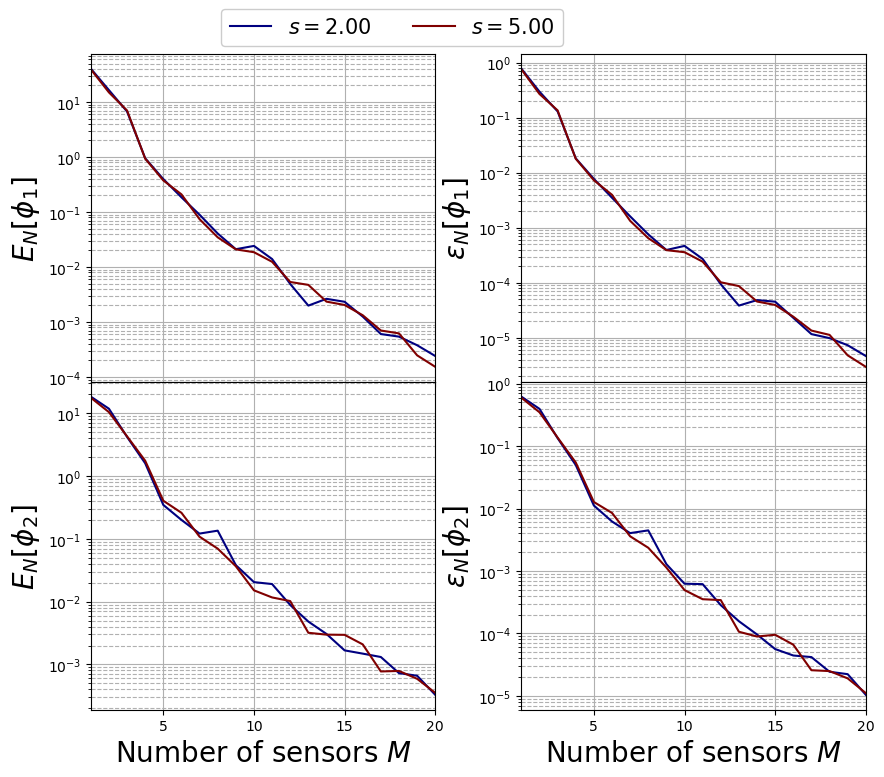

In [12]:
TrainingErrFig, axs = plt.subplots(nrows = len(var_names), ncols = 2, sharex = True, figsize = (10,8) )

M = np.arange(1,Mmax+1,1)

for ii in range(len(var_names)):
    
    colors = cm.jet(np.linspace(0,1,len(s)))
    for jj in range(len(s)):
        axs[ii, 0].semilogy(M, train_abs_err[:Mmax, ii, jj], c=colors[jj], label = r'$s={:.2f}'.format(s[jj])+'$')
        axs[ii, 1].semilogy(M, train_rel_err[:Mmax, ii, jj], c=colors[jj], label = r'$s={:.2f}'.format(s[jj])+'$')

    axs[ii, 0].set_xticks(np.arange(0,Mmax+1,5))
    axs[ii, 0].set_xlim(1,Mmax)
    axs[ii, 0].set_ylabel(r"$E_N["+tex_var_names[ii]+"]$",fontsize=20)
    axs[ii, 1].set_ylabel(r"$\varepsilon_N["+tex_var_names[ii]+"]$",fontsize=20)
    
axs[1, 0].set_xlabel(r"Number of sensors $M$",fontsize=20)
axs[1, 1].set_xlabel(r"Number of sensors $M$",fontsize=20)
    
for ax in axs.flatten():
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')

Line, Label = axs[0,0].get_legend_handles_labels()

TrainingErrFig.legend(Line, Label, fontsize=15, loc=(0.25,0.94), ncols = len(s), framealpha = 1)
TrainingErrFig.subplots_adjust(hspace = 0, wspace=0.25, top = 0.93)

## Calculation of the Lebesgue Constant
The Lebesgue Constant $\Lambda_M$ is important for the GEIM algorithm, since it appears in the *a-priori* error estimation for the reduction technique. The procedure on how this is computed was introduced in [Maday et al., (2015)](https://www.sciencedirect.com/science/article/pii/S0045782515000389?via%3Dihub).

The Lebesgue constant can be computed using the function `computeLebesgue`: it requires the magic functions and the magic sensors as input.

In [13]:
from pyforce.offline.geim import computeLebesgue

Lebesgue_const = np.zeros((Mmax, len(var_names), len(s)))

bar = LoopProgress('Computing Lebesgue', final = len(var_names) * len(s))

for field_i in range(len(var_names)):
    for jj in range(len(s)):
        Lebesgue_const[:, field_i, jj] = computeLebesgue(geim_data[var_names[field_i]][jj].magic_fun,
                                                        geim_data[var_names[field_i]][jj].magic_sens)
        
        bar.update(1, percentage=False)

Computing Lebesgue: 4.000 / 4.00 - 4.632 s/it


Let us plot it to see the effect of the point spread

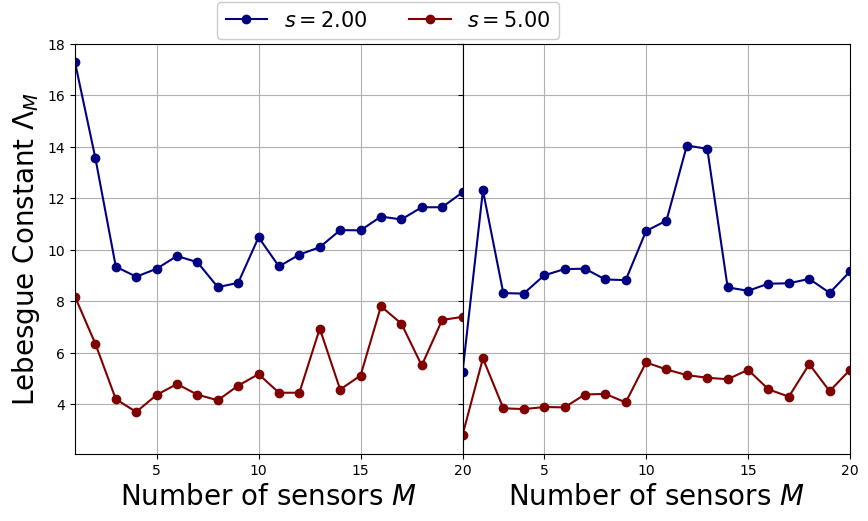

In [14]:
LebesgueFig, axs = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True, figsize = (10,5) )

for field_i in range(len(var_names)):
    colors = cm.jet(np.linspace(0,1,len(s)))
    for jj in range(len(s)):
        axs[field_i].plot(M, Lebesgue_const[:, field_i, jj], '-o', c=colors[jj], label = r'$s={:.2f}'.format(s[jj])+'$')

    axs[field_i].set_xlabel(r"Number of sensors $M$",fontsize=20)
    axs[field_i].grid(which='major',linestyle='-')
    axs[field_i].grid(which='minor',linestyle='--')
    
    axs[field_i].set_xticks(np.arange(0, Mmax+1,5))
    axs[field_i].set_xlim(1, Mmax)
    
axs[0].set_ylabel(r"Lebesgue Constant $\Lambda_M$",fontsize=20)
for ax in axs.flatten():
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')
    
Line, Label = axs[0].get_legend_handles_labels()

LebesgueFig.legend(Line, Label, fontsize=15, loc=(0.25,0.925), ncols = len(s), framealpha = 1)
LebesgueFig.subplots_adjust(hspace = 0, wspace=0, top = 0.93)

## Post Process

In this last section, *pyvista* is used to make some contour plots of the magic functions and sensors for the fast and thermal flux.

Let us plot the first 6 magic functions of each variable, for $s=2$: in particular, contour plots of the fast and thermal flux are shown.

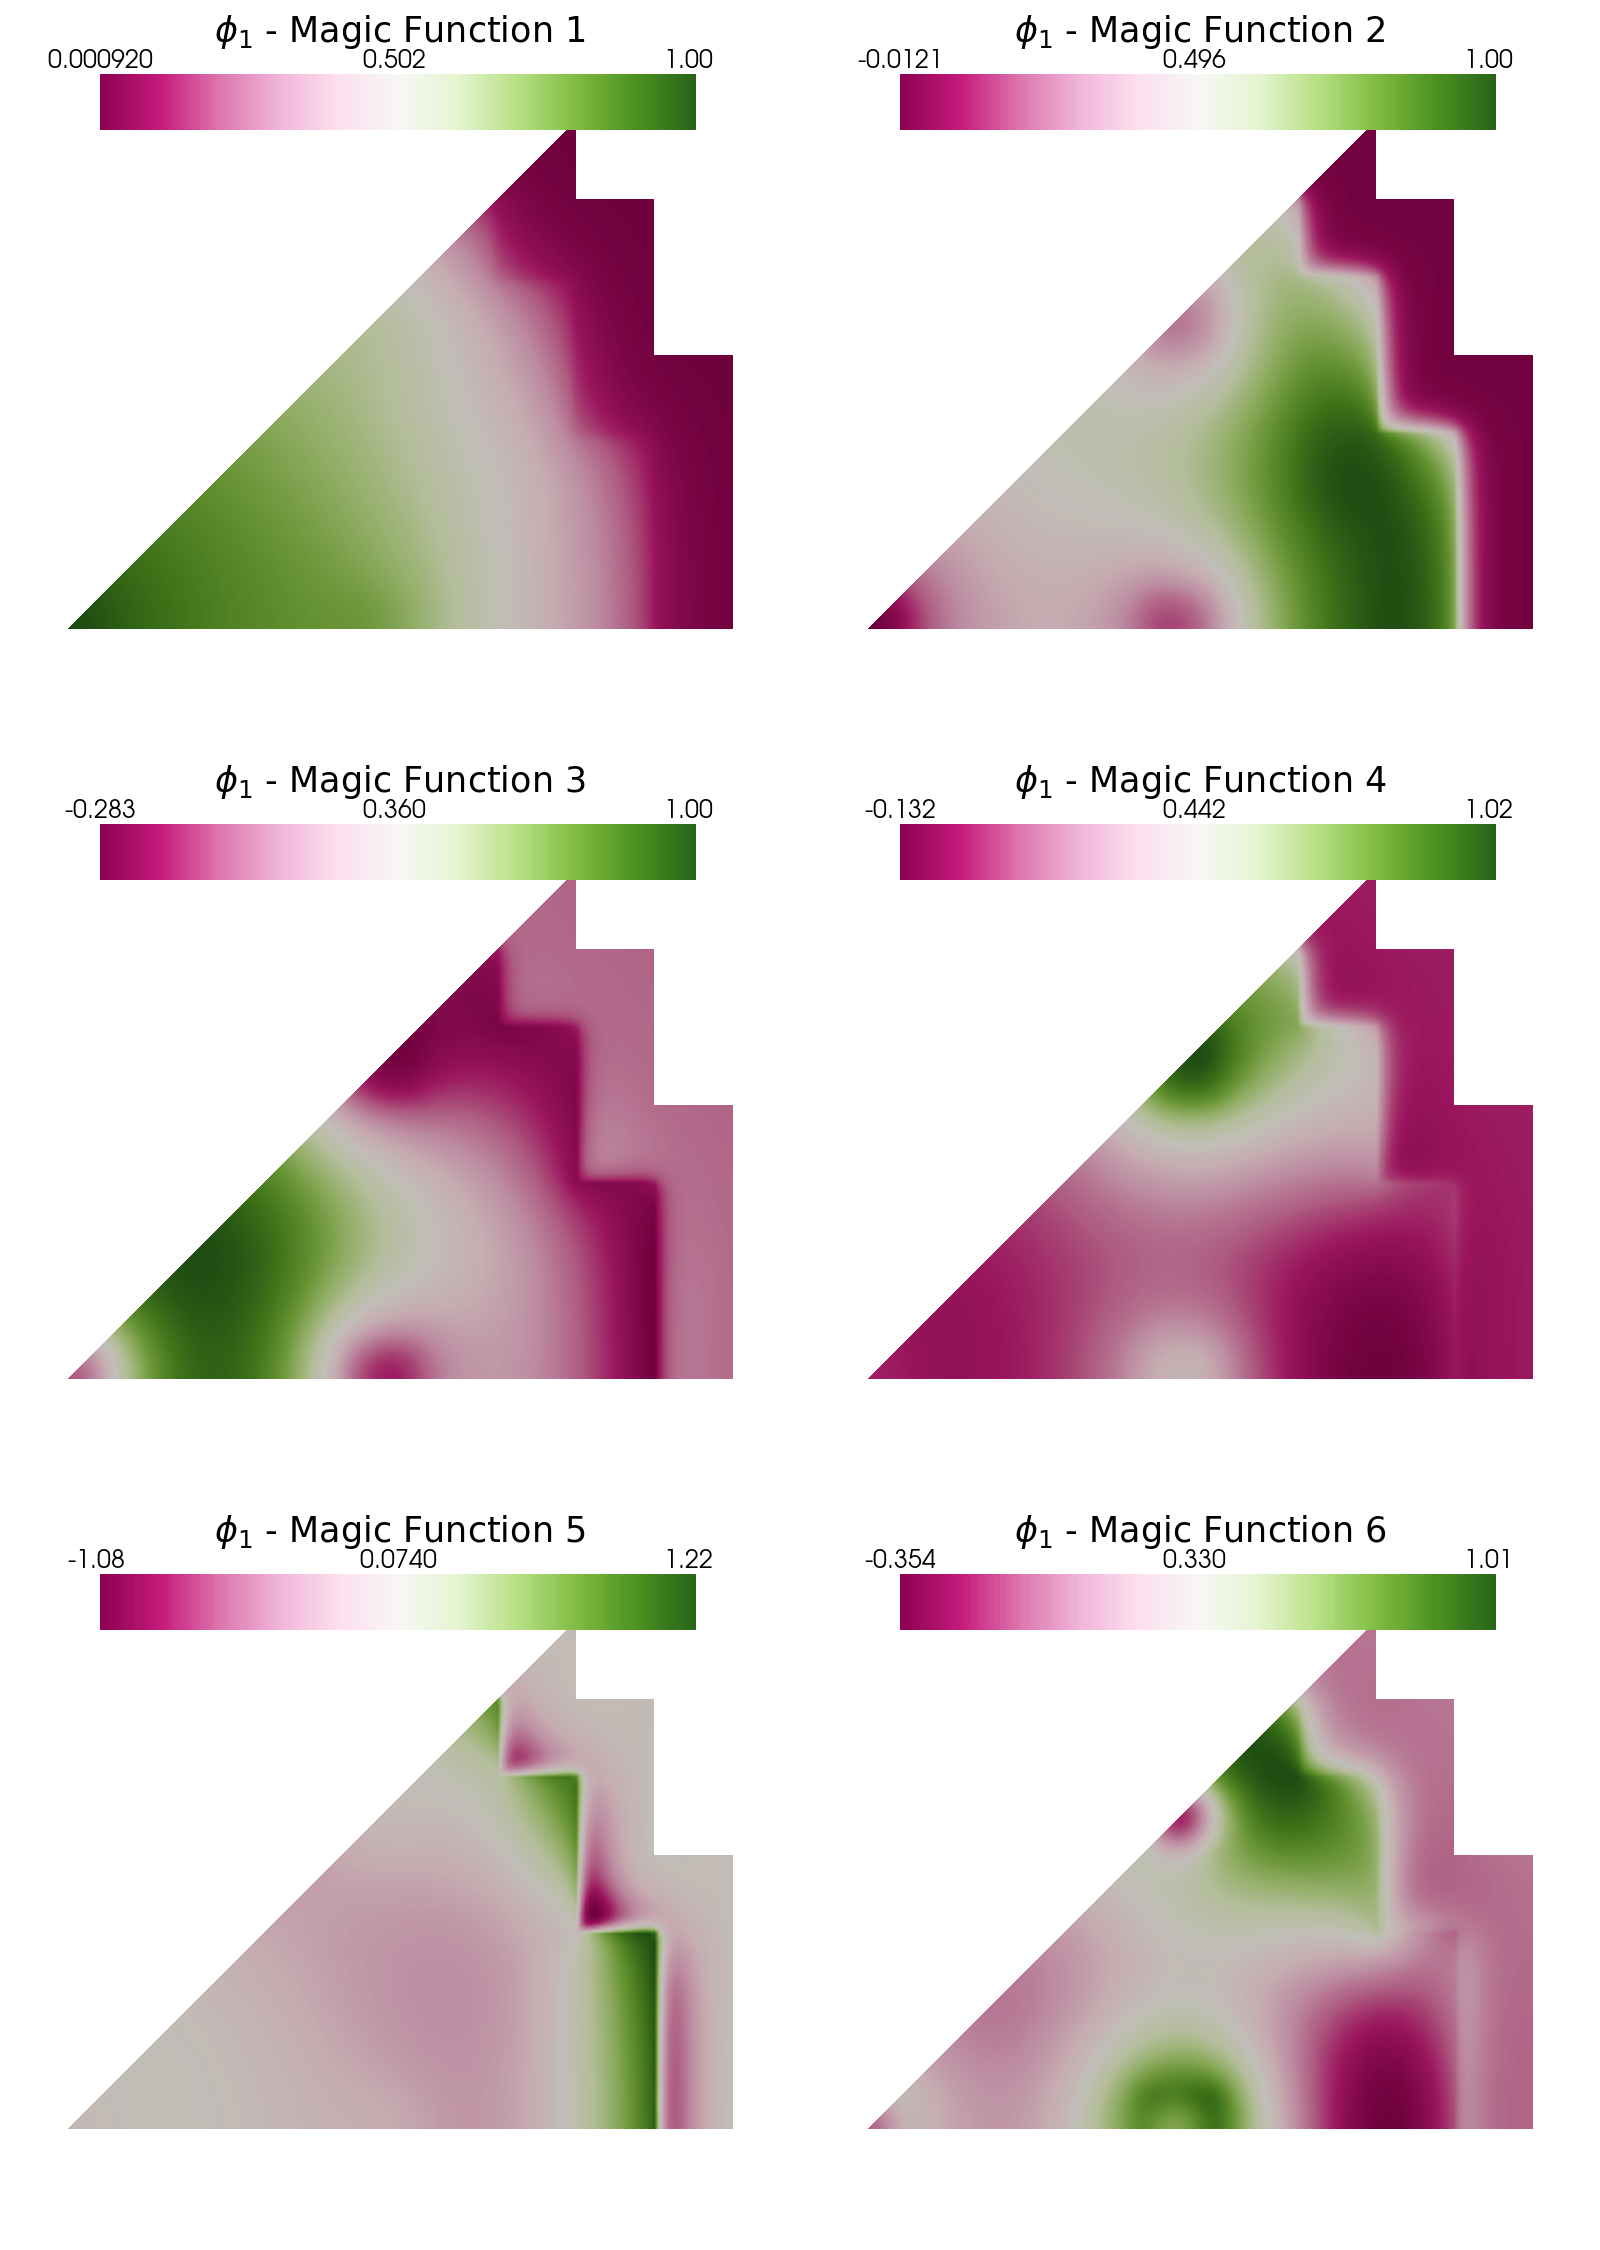

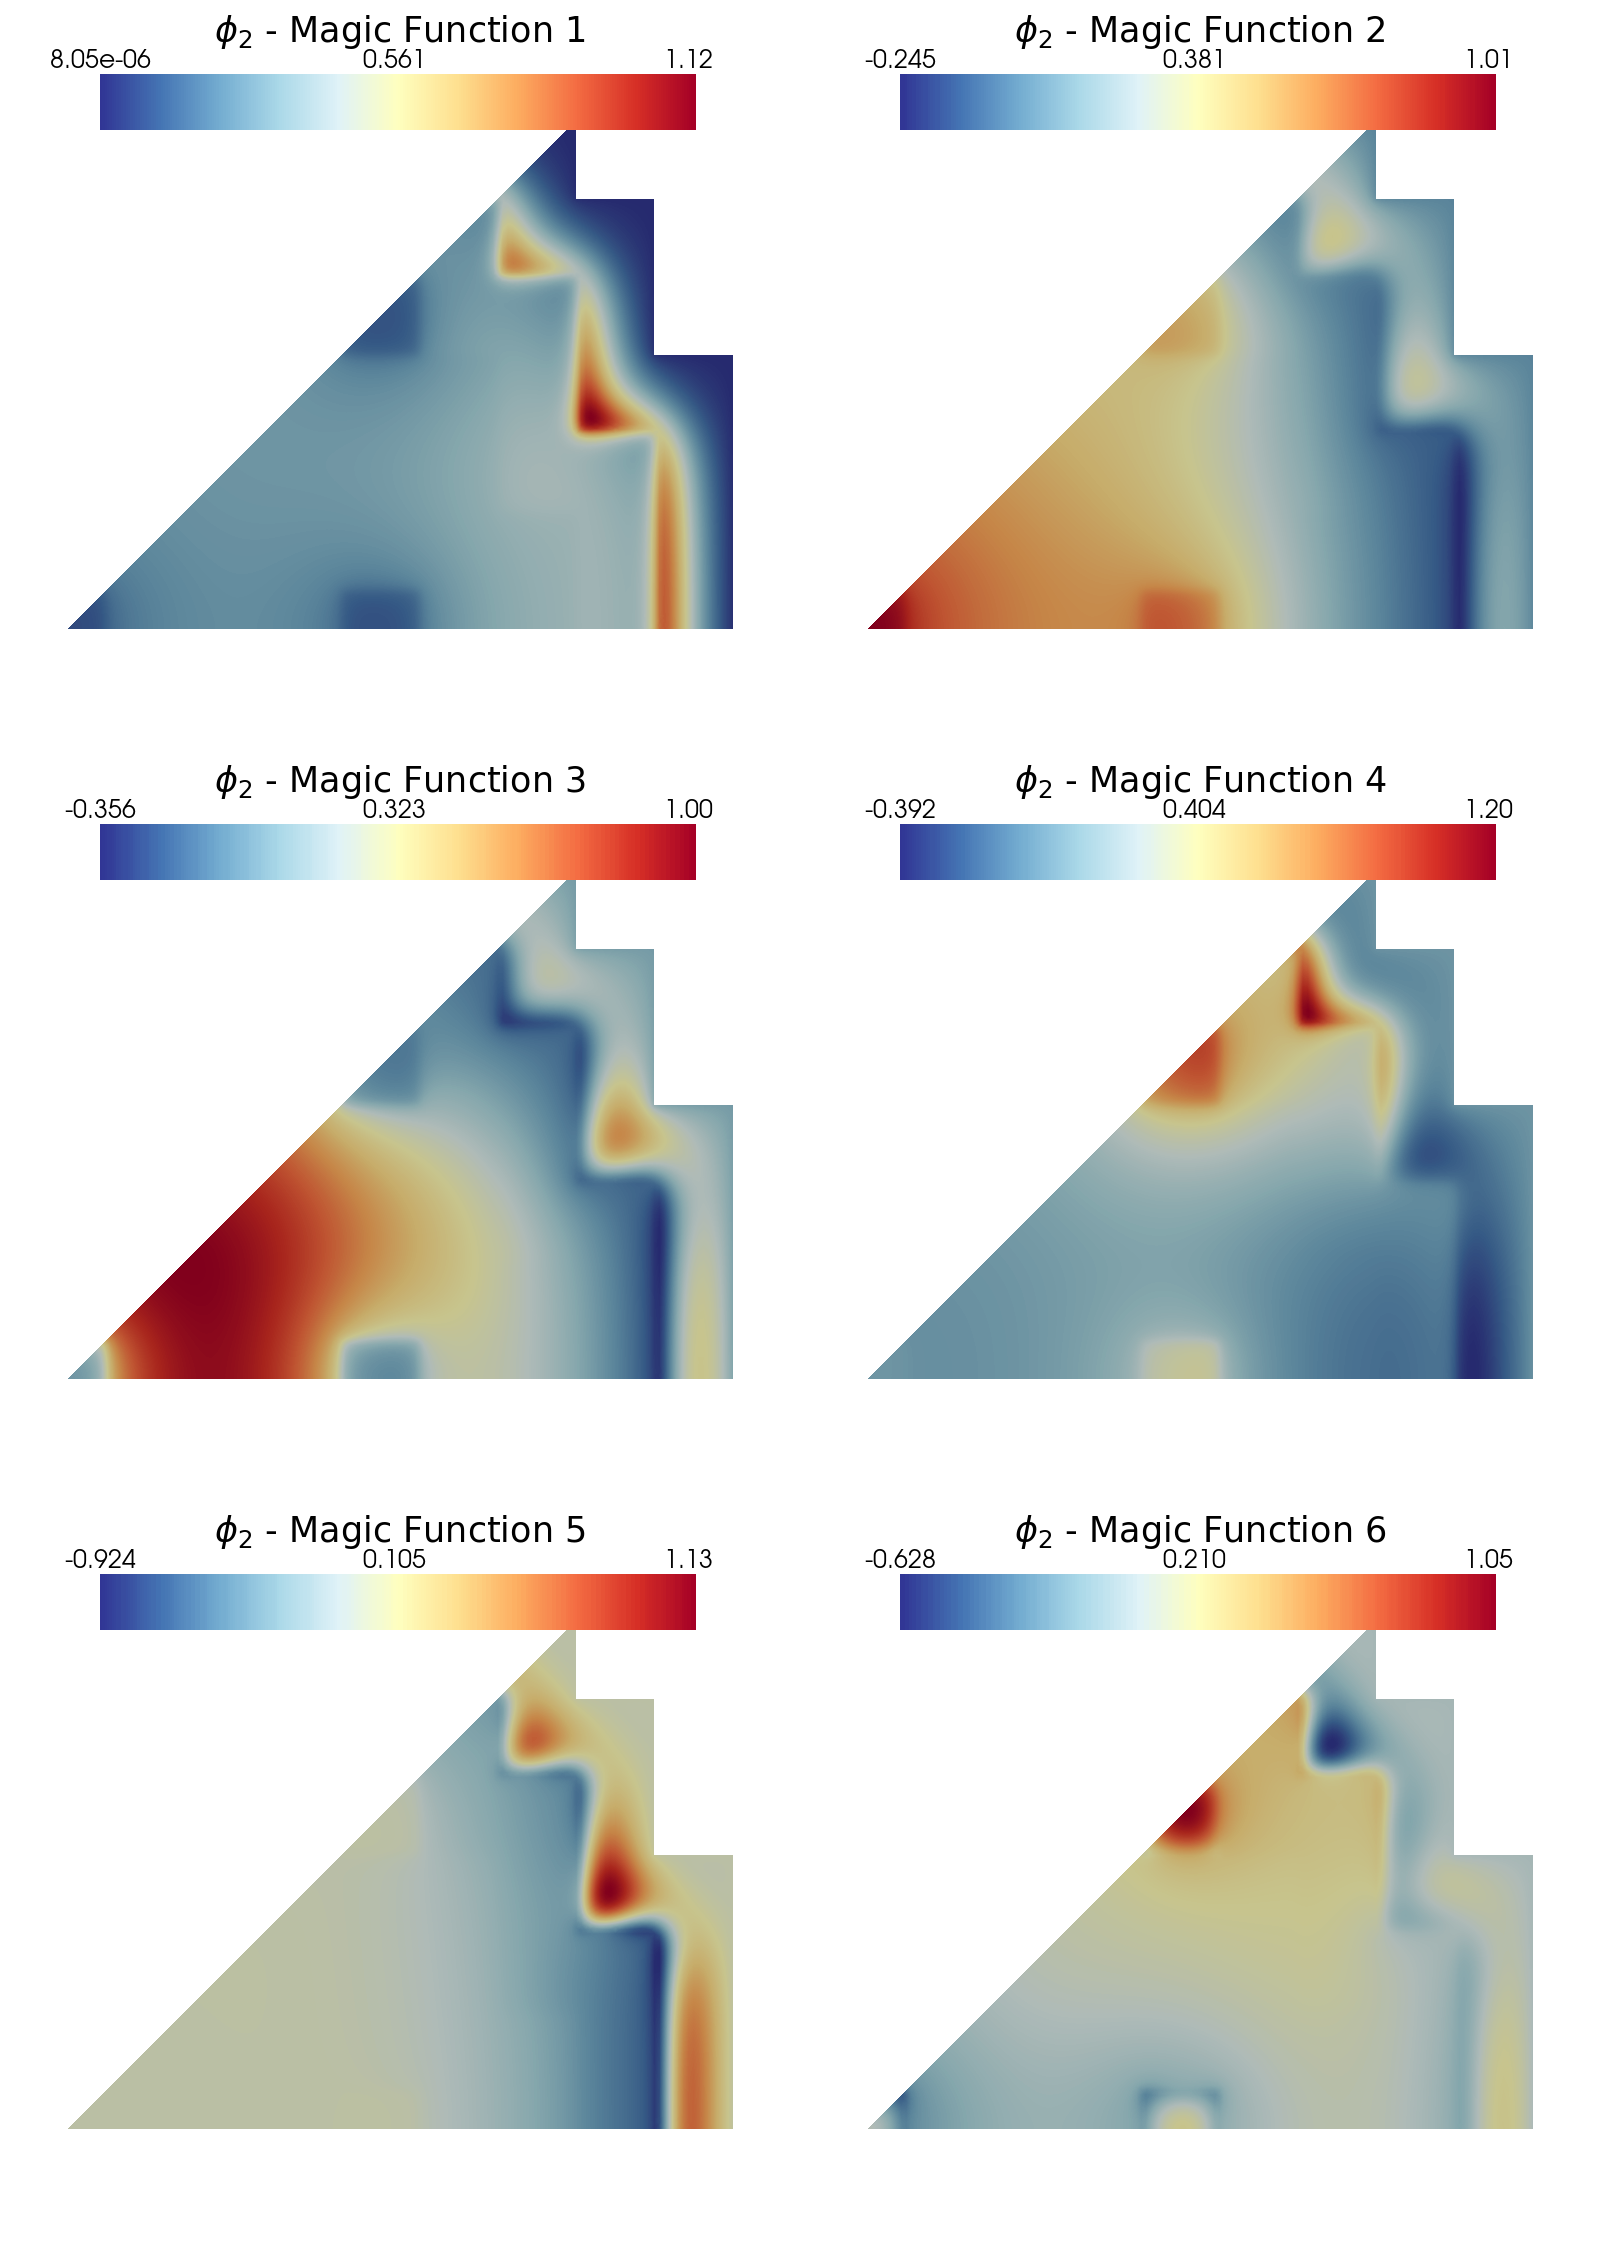

In [15]:
from contour_plotting import plot_modes

plot_modes(geim_data[var_names[0]][0].magic_fun, tex_var_names[0], 
           shape = [3,2], colormap=cm.PiYG, title = 'Magic Function')
plot_modes(geim_data[var_names[1]][0].magic_fun, tex_var_names[1], 
           shape = [3,2], colormap=cm.RdYlBu_r, title = 'Magic Function')

In the end, let us plot the sensors positions for the fast and thermal flux, for each value of $s$.

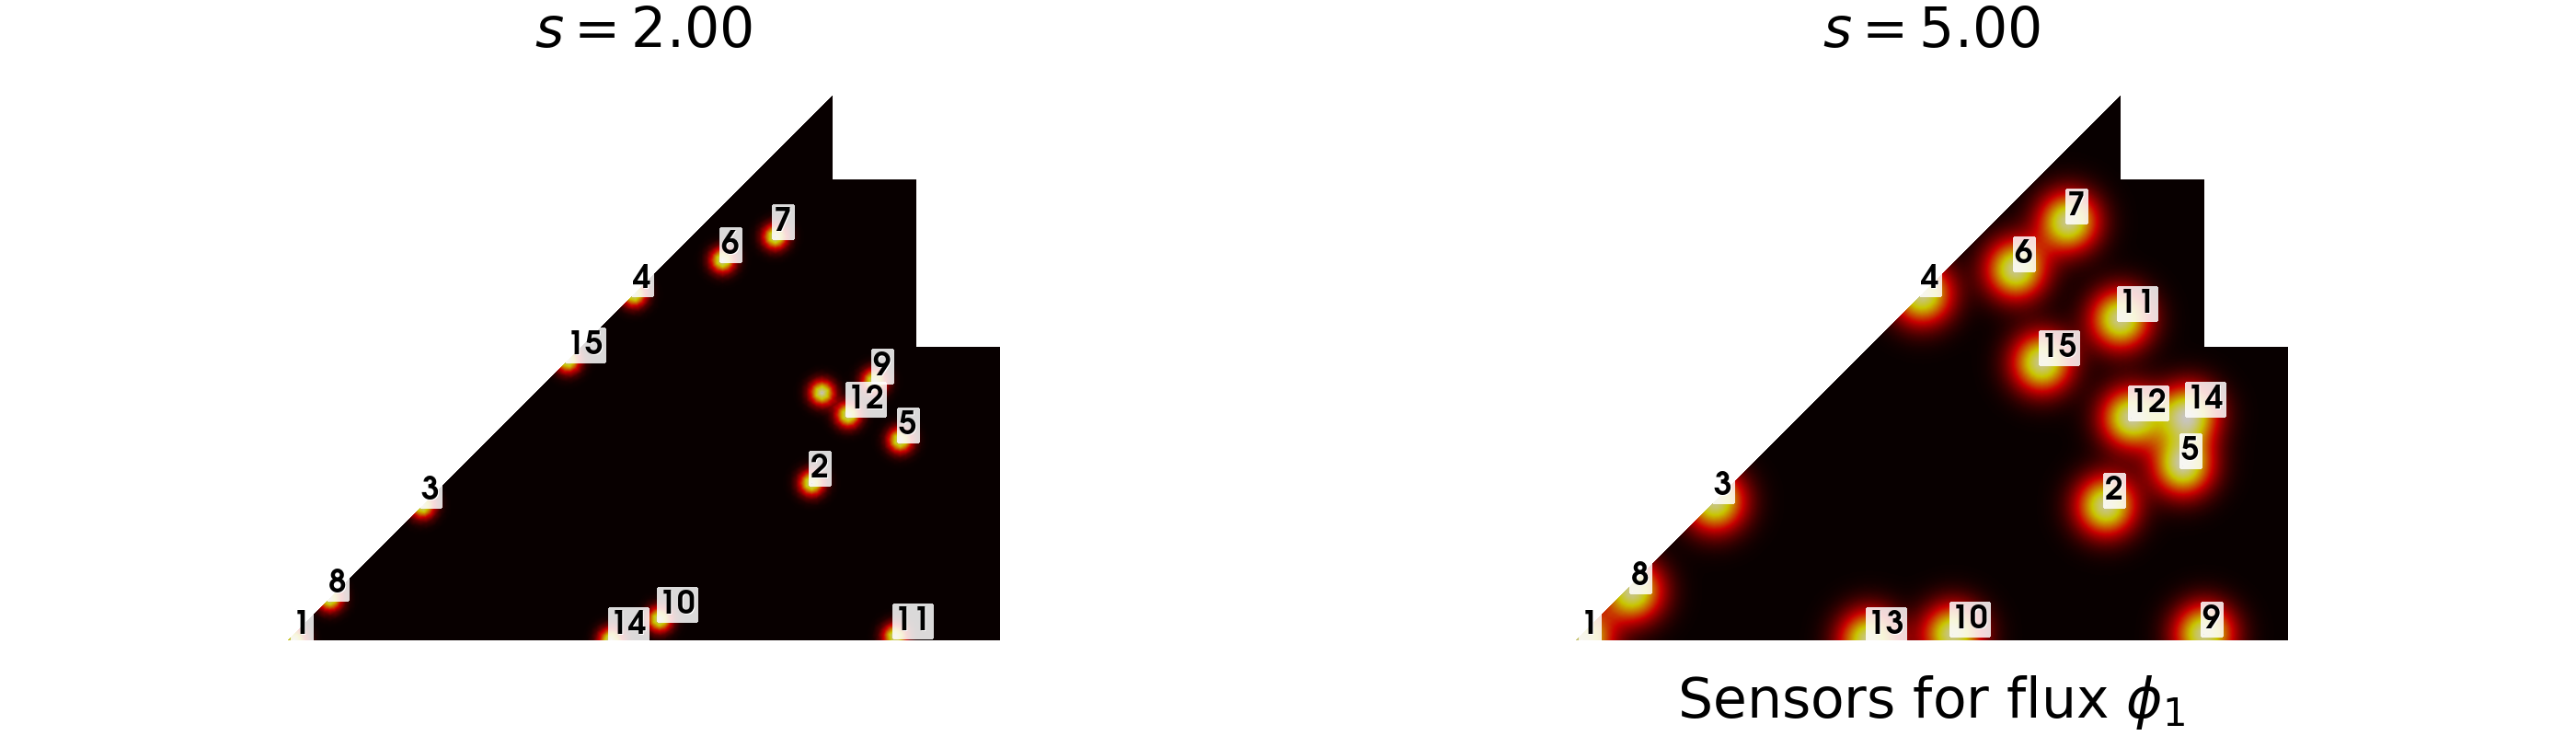

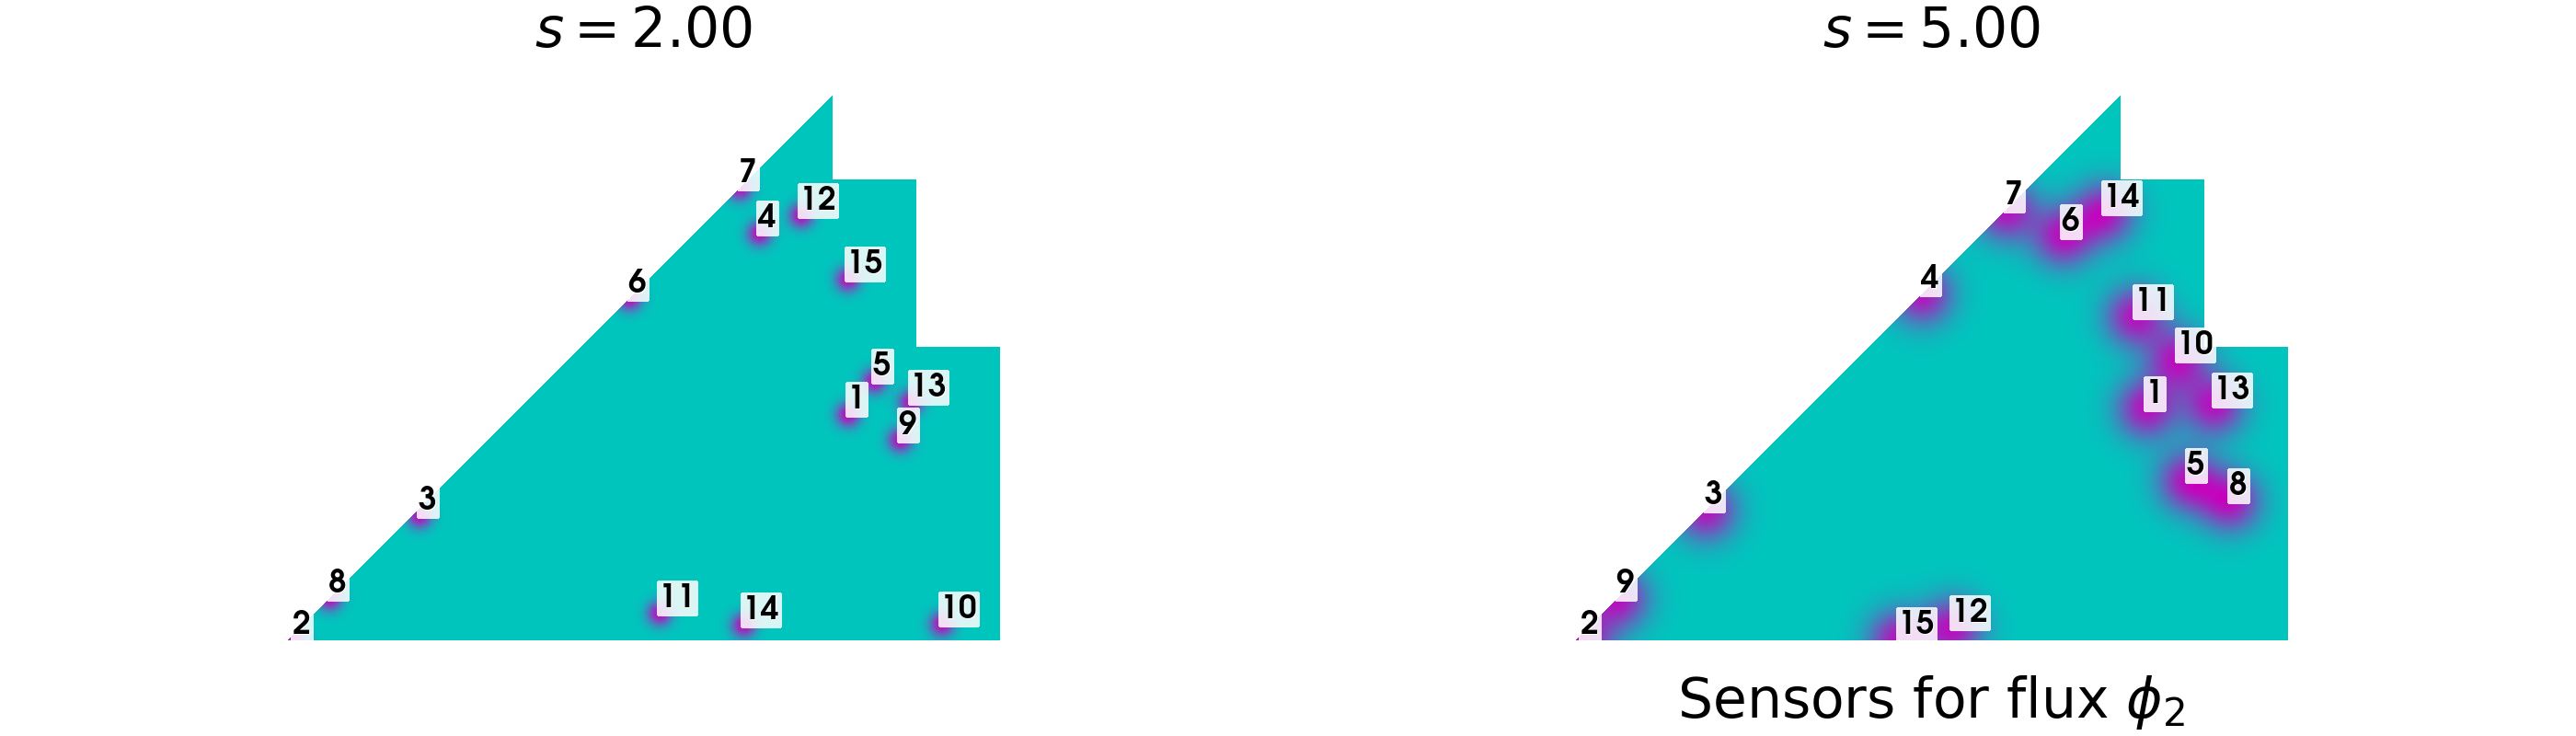

In [16]:
from contour_plotting import plot_geim_sensors

plot_geim_sensors(geim_data[var_names[0]], 15, [r'$s={:.2f}$'.format(ss) for ss in s], 0, cmap=cm.hot)
plot_geim_sensors(geim_data[var_names[1]], 15, [r'$s={:.2f}$'.format(ss) for ss in s], 1, cmap=cm.cool)

The first 3 positions are identical for the two values of $s$, then some differences are observed. In the coming notebooks, only the case with $s=2$ will be considered since better represents the reality of a flux sensors.